# Model

In [1]:
from spynet_arch import *
import pandas as pd

# Inference

## Inference function

In [3]:
netNetwork = None

##########################################################

def estimate(tenOne, tenTwo):
    global netNetwork

    if netNetwork is None:
        netNetwork = SpyNet().cuda().eval()
    # end

    assert(tenOne.shape[1] == tenTwo.shape[1])
    assert(tenOne.shape[2] == tenTwo.shape[2])

    intWidth = tenOne.shape[2]
    intHeight = tenOne.shape[1]

#     assert(intWidth == 1024) # remember that there is no guarantee for correctness, comment this line out if you acknowledge this and want to continue
#     assert(intHeight == 416) # remember that there is no guarantee for correctness, comment this line out if you acknowledge this and want to continue

    tenPreprocessedOne = tenOne.cuda().view(1, 3, intHeight, intWidth)
    tenPreprocessedTwo = tenTwo.cuda().view(1, 3, intHeight, intWidth)

    intPreprocessedWidth = int(math.floor(math.ceil(intWidth / 32.0) * 32.0))
    intPreprocessedHeight = int(math.floor(math.ceil(intHeight / 32.0) * 32.0))

    tenPreprocessedOne = torch.nn.functional.interpolate(input=tenPreprocessedOne, size=(intPreprocessedHeight, intPreprocessedWidth), mode='bilinear', align_corners=False)
    tenPreprocessedTwo = torch.nn.functional.interpolate(input=tenPreprocessedTwo, size=(intPreprocessedHeight, intPreprocessedWidth), mode='bilinear', align_corners=False)

    tenFlow = torch.nn.functional.interpolate(input=netNetwork(tenPreprocessedOne, tenPreprocessedTwo), size=(intHeight, intWidth), mode='bilinear', align_corners=False)

    tenFlow[:, 0, :, :] *= float(intWidth) / float(intPreprocessedWidth)
    tenFlow[:, 1, :, :] *= float(intHeight) / float(intPreprocessedHeight)

    return tenFlow[0, :, :, :].cpu()

## Run inference

In [31]:
tenOne = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strOne))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
tenTwo = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strTwo))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))

tenOutput = estimate(tenOne, tenTwo)



In [32]:
tenOutput.shape

torch.Size([2, 416, 1024])

In [33]:
print("tenOne.shape ==> ",tenOne.shape)
print("tenTwo.shape ==> ",tenTwo.shape)

tenOne.shape ==>  torch.Size([3, 416, 1024])
tenTwo.shape ==>  torch.Size([3, 416, 1024])


In [11]:
H = tenOutput.numpy().transpose(1, 2, 0)

In [12]:
H.shape

(416, 1024, 2)

## Visualization

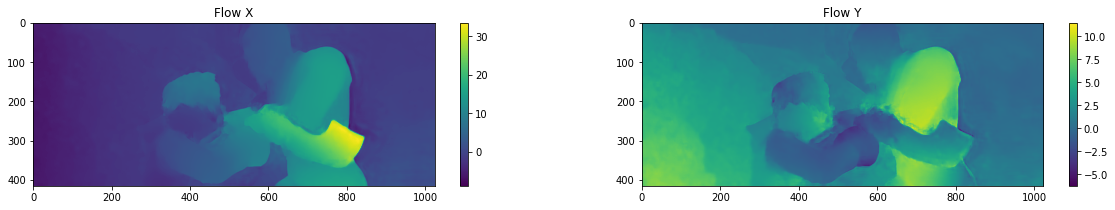

In [26]:
import numpy as np
import matplotlib.pyplot as plt

H = tenOutput.numpy().transpose(1, 2, 0)

fig = plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)
plt.title('Flow X')
plt.imshow(H[:,:,0])
plt.colorbar(orientation='vertical')


plt.subplot(1, 2, 2)
plt.title("Flow Y")
plt.imshow(H[:,:,1])
plt.colorbar(orientation='vertical')
plt.savefig("flow_out.png")
plt.show()

# Use-case Speckle images

## Try infrence

In [6]:
# Define path for speckle images 
in_1 = "/home/anas/new_CNN/pytorch-spynet/images/Star_frames/Noiseless_frames/Star1.tif"
in_2 = "/home/anas/new_CNN/pytorch-spynet/images/Star_frames/Noiseless_frames/Star2.tif"

## Run inference

In [44]:
from imageio import imread
img1 =  np.array(imread(in_1))
img2 =  np.array(imread(in_2))
img1 = img1/255
img2 = img2/255

img1 = torch.from_numpy(img1).float()
img2 = torch.from_numpy(img2).float()       

In [41]:
print("img1.shape ==> ",img1.shape)
print("img2.shape ==> ",img2.shape)


img1.shape ==>  torch.Size([501, 2000])
img2.shape ==>  torch.Size([501, 2000])


In [47]:
img1 = img1[np.newaxis, ...]       
img2 = img2[np.newaxis, ...]

img1 = img1[np.newaxis, ...]       
img2 = img2[np.newaxis, ...]

in_ref = torch.cat([img1,img1,img1],1)
in_def = torch.cat([img2,img2,img2],1)

in_ref = in_ref.squeeze()
in_def = in_def.squeeze()

# tenOne = torch.FloatTensor(numpy.ascontiguousarray(img1).transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0))
# tenTwo = torch.FloatTensor(numpy.ascontiguousarray(img2).transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0))

In [48]:
print("in_ref.shape ==> ",in_ref.shape)
print("in_def.shape ==> ",in_def.shape)

in_ref.shape ==>  torch.Size([3, 501, 2000])
in_def.shape ==>  torch.Size([3, 501, 2000])


In [49]:
speckleFlow = estimate(in_ref, in_def)

In [50]:
speckleFlow.shape

torch.Size([2, 501, 2000])

In [51]:
H = speckleFlow.numpy().transpose(1, 2, 0)

In [52]:
H.shape

(501, 2000, 2)

## Visualization

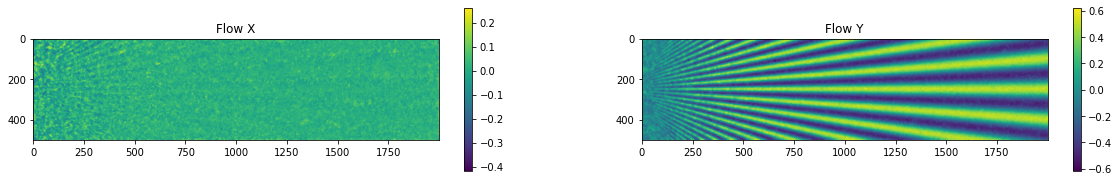

In [82]:
import numpy as np
import matplotlib.pyplot as plt

H = speckleFlow.numpy().transpose(1, 2, 0)

fig = plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)
plt.title('Flow X')
plt.imshow(H[:,:,0])
plt.colorbar(orientation='vertical')


plt.subplot(1, 2, 2)
plt.title("Flow Y")
plt.imshow(H[:,:,1])
plt.colorbar(orientation='vertical')
plt.savefig("star_flow.png")
plt.show()

In [75]:
pd.set_option("display.precision", 3)
flow_x = pd.DataFrame(H[:,:,0].flatten()) 
flow_y = pd.DataFrame(H[:,:,1].flatten())

In [76]:
flow_x.shape

(1002000, 1)

In [77]:
flow_x.describe()

,0
count,1.002e+06
mean,1.292e-02
std,3.311e-02
min,-4.183e-01
25%,-4.682e-03
50%,1.339e-02
75%,3.147e-02
max,2.632e-01


In [78]:
flow_y.describe()

,0
count,1.002e+06
mean,-6.507e-03
std,3.139e-01
min,-6.168e-01
25%,-2.952e-01
50%,-2.120e-02
75%,2.835e-01
max,6.216e-01


In [79]:
# Get ABS values
flow_x_abs = flow_x.apply(np.abs)
flow_y_abs = flow_y.apply(np.abs)

In [80]:
flow_x_abs.describe()

,0
count,1.002e+06
mean,2.675e-02
std,2.341e-02
min,9.013e-09
25%,9.850e-03
50%,2.098e-02
75%,3.682e-02
max,4.183e-01


In [81]:
flow_y_abs.describe()

,0
count,1.002e+06
mean,2.741e-01
std,1.532e-01
min,2.106e-08
25%,1.364e-01
50%,2.897e-01
75%,4.151e-01
max,6.216e-01
